The most widely used application of NLP is *classification*, i.e. is classifying a document to some category.
1. Sentiment Analysis
2. Author Identification
3. Legal Discovery
4. Organizing Documents by Topics
5. Triaging Inbound Emails

Classification models can also be used to solve problems that are obviously not appropriate looking at first. For instance, consider the [U.S. Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/) competition. 
Following is the GOAL of this competition: Compare 2 words or short phrases and score them whether they are similar or not.
* Score of `1` means the 2 inputs have identical meaning
* Score of `0` meands the 2 inputs have totally different meaning
* One instance: ***abatement*** and ***eliminating process*** have a score of `0.5`, meaning they are somewhat similar, but not identical.

This can be turned into a classification model by representing each instance like below:
* `"TEXT1:abatement;TEXT2:eliminating process"`
* Choose a similarity category: `"Different;Similar;Identical"`

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
!ls -la /kaggle/input
!head /kaggle/input/us-patent-phrase-to-phrase-matching/train.csv

total 8
drwxr-xr-x 4 root   root    4096 Jan 14 03:27 .
drwxr-xr-x 5 root   root    4096 Jan 14 03:27 ..
drwxr-xr-x 2 nobody nogroup    0 Oct 11 13:33 us-patent-phrase-to-phrase-matching
drwxr-xr-x 2 nobody nogroup    0 Jan 14 03:27 us-patent-phrase-to-phrase-matching-dataset
id,anchor,target,context,score
37d61fd2272659b1,abatement,abatement of pollution,A47,0.5
7b9652b17b68b7a4,abatement,act of abating,A47,0.75
36d72442aefd8232,abatement,active catalyst,A47,0.25
5296b0c19e1ce60e,abatement,eliminating process,A47,0.5
54c1e3b9184cb5b6,abatement,forest region,A47,0
067203128142739c,abatement,greenhouse gases,A47,0.25
061d17f04be2d1cf,abatement,increased rate,A47,0.25
e1f44e48399a2027,abatement,measurement level,A47,0.25
0a425937a3e86d10,abatement,minimising sounds,A47,0.5


In [3]:
import pandas as pd
from pathlib import Path

In [4]:
data_path = Path('/kaggle/input/us-patent-phrase-to-phrase-matching/')
!ls {data_path}

sample_submission.csv  test.csv  train.csv


In [5]:
df = pd.read_csv(data_path/'train.csv')
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [6]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [7]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; TEXT3: ' + df.anchor
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; TEX...
1    TEXT1: A47; TEXT2: act of abating; TEXT3: abat...
2    TEXT1: A47; TEXT2: active catalyst; TEXT3: aba...
3    TEXT1: A47; TEXT2: eliminating process; TEXT3:...
4    TEXT1: A47; TEXT2: forest region; TEXT3: abate...
Name: input, dtype: object

## Tokenization
**Tokenization**: Split each text up into words (or actually, as we'll see, into tokens)
> Transformers uses `Dataset` object to store a dataset. Following is how you load a dataset from a dataframe:

In [8]:
from datasets import Dataset, DatasetDict
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

**Numericalization**: Convert each word (or token) into a number. 

The details of how tokenization and numerecalization is done depends on the particular model we use. So, we'll pick a model. A resonable starting point for nearly any NLP problem is to use the below model (replace 'small' with 'large' for slower but more accurate predictions):

`AutoTokenizer` will create a tokenizer appropriate for a given model:

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_nm = 'microsoft/deberta-v3-small'
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
print(tokz.tokenize("G'day folks, this is Aman from New Delhi"))

# Uncommon words would be split into pieces
print(tokz.tokenize("A platypus is an ornithorhynchus anatinus."))

['▁G', "'", 'day', '▁folks', ',', '▁this', '▁is', '▁Aman', '▁from', '▁New', '▁Delhi']
['▁A', '▁platypus', '▁is', '▁an', '▁or', 'ni', 'tho', 'rhynch', 'us', '▁an', 'at', 'inus', '.']


In [11]:
print(ds.column_names)
print(ds['input'][:5])
print(tokz(ds['input'][:5]))

['id', 'anchor', 'target', 'context', 'score', 'input']
['TEXT1: A47; TEXT2: abatement of pollution; TEXT3: abatement', 'TEXT1: A47; TEXT2: act of abating; TEXT3: abatement', 'TEXT1: A47; TEXT2: active catalyst; TEXT3: abatement', 'TEXT1: A47; TEXT2: eliminating process; TEXT3: abatement', 'TEXT1: A47; TEXT2: forest region; TEXT3: abatement']
{'input_ids': [[1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 47284, 265, 6435, 346, 54453, 508, 294, 47284, 2], [1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 1727, 265, 266, 17441, 510, 346, 54453, 508, 294, 47284, 2], [1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 1636, 14930, 346, 54453, 508, 294, 47284, 2], [1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 10181, 568, 346, 54453, 508, 294, 47284, 2], [1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 4054, 1488, 346, 54453, 508, 294, 47284, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
# Define function to tokenize our inputs
def tokenize_inputs(x):
    return tokz(x['input'])

# Run this parallely on every row of the dataset using map() function
tok_ds = ds.map(tokenize_inputs, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [13]:
row = tok_ds[0]
print(row['input'], row['input_ids'])
print(tokz.tokenize(row['input']))

TEXT1: A47; TEXT2: abatement of pollution; TEXT3: abatement [1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 47284, 265, 6435, 346, 54453, 508, 294, 47284, 2]
['▁TEXT', '1', ':', '▁A', '47', ';', '▁TEXT', '2', ':', '▁abatement', '▁of', '▁pollution', ';', '▁TEXT', '3', ':', '▁abatement']


In [14]:
token_dictionary = tokz.get_vocab()
print(token_dictionary['▁Bicycles'])

80118


In [15]:
tok_ds = tok_ds.rename_columns({'score': 'labels'})
tok_ds['labels'][:5]

[0.5, 0.75, 0.25, 0.5, 0.0]

In [16]:
df['score'].value_counts()

0.50    12300
0.25    11519
0.00     7471
0.75     4029
1.00     1154
Name: score, dtype: int64

## Test & Validation Sets
The validation set is only ever used to observe how we are doing. It is neved used as inputs to the training data.
Transformers uses a `DatasetDict` for holding the training and validation set. To create one that contains a validation set with 25% data, and 75% of training set, we would use `train_test_split()`.
In practice though, a random split like we have used below might not be a good idea:
> *'One of the most likely culprits for this disconnect between results in development vs results in production is a poorly chosen validation set (or even worse, no validation set at all). Depending on the nature of your data, choosing a validation set can be the most important step. Although sklearn offers a train_test_split method, this method takes a random subset of the data, which is a poor choice for many real-world problems'*

Recommended Reading: https://www.fast.ai/posts/2017-11-13-validation-sets.html

The test set is yet another dataset that's held out from training. But it's held out from reporting metrics too! The accuracy of your model on the test set is only ever checked after you've completed your entire training process, including trying different models, training methods, data processing, etc.
Below, we would use the `eval_df` as the test set for this task.

In [17]:
eval_df = pd.read_csv(data_path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [18]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [19]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; TEXT3: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tokenize_inputs, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

## Metrics and Correlation: A Detour
According to this competition's evaluation page, "submissions are evaluated on the Pearson correlation coefficient between the predicted and actual similarity scores." It is the most widely used measure of the degree of relationship between two variables. It can vary between -1, which means perfect inverse correlation, and +1, which means perfect positive correlation.

To get an intution into Pearson Correlation Coefficient, let's look into the California Housing dataset.

In [20]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)

In [21]:
print(housing.keys())
print(housing['data'])
print(housing['target'])

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.1

In [22]:
housing['data'].head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [23]:
housing = housing['data'].join(housing['target']).sample(1000, random_state=42)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20046,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,0.47700
3024,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46,0.45800
15663,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44,5.00001
20484,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72,2.18600
9814,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93,2.78000


In [24]:
len(housing)

1000

We can see all the correlations for every combinations of columns in the dataset by calling `np.corrcoef()`

In [25]:
np.set_printoptions(precision=2, suppress=True)
np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.1 ,  0.51, -0.07, -0.  , -0.02, -0.1 ,  0.  ,  0.69],
       [-0.1 ,  1.  , -0.18, -0.11, -0.33,  0.03,  0.03, -0.13,  0.1 ],
       [ 0.51, -0.18,  1.  ,  0.67, -0.06, -0.01,  0.13, -0.05,  0.26],
       [-0.07, -0.11,  0.67,  1.  , -0.04, -0.08,  0.1 , -0.  , -0.04],
       [-0.  , -0.33, -0.06, -0.04,  1.  ,  0.15, -0.11,  0.11, -0.03],
       [-0.02,  0.03, -0.01, -0.08,  0.15,  1.  , -0.17,  0.19, -0.26],
       [-0.1 ,  0.03,  0.13,  0.1 , -0.11, -0.17,  1.  , -0.92, -0.14],
       [ 0.  , -0.13, -0.05, -0.  ,  0.11,  0.19, -0.92,  1.  , -0.06],
       [ 0.69,  0.1 ,  0.26, -0.04, -0.03, -0.26, -0.14, -0.06,  1.  ]])

In [26]:
np.corrcoef(housing.MedHouseVal, housing.MedInc)

array([[1.  , 0.69],
       [0.69, 1.  ]])

In [27]:
def corr(x, y): return np.corrcoef(x, y)[0][1]

In [28]:
corr(housing.MedHouseVal, housing.MedInc)

0.6887874432146509

In [29]:
def show_corr(df, a, b):
    x, y = df[a], df[b]
    plt.scatter(x, y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

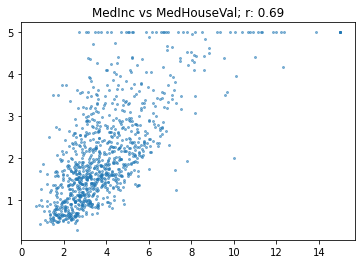

In [30]:
show_corr(housing, 'MedInc', 'MedHouseVal')

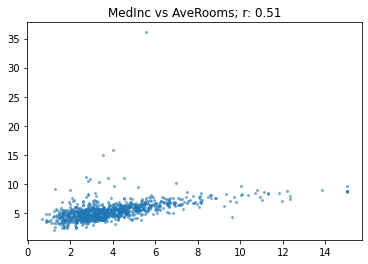

In [31]:
show_corr(housing, 'MedInc', 'AveRooms')

In the above plot, we observe that `r` is much lower than the `income vs valuation` case. The reason is that there are a lot of outliers.

`r` is very sensitive to outliers. In the current case, the houses with a very high number of rooms don't tend to be that valuable. Let's remove the ourliers and observe the correlation again

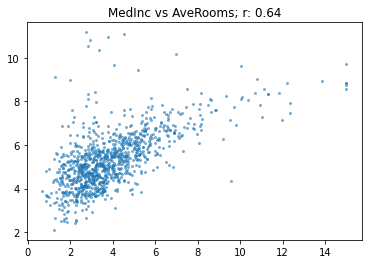

In [32]:
subset = housing[housing.AveRooms < 15]
show_corr(subset, 'MedInc', 'AveRooms')

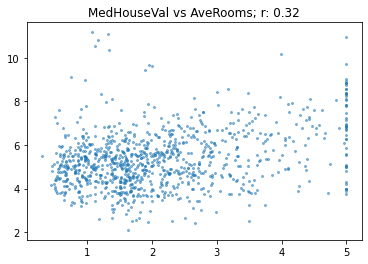

In [33]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

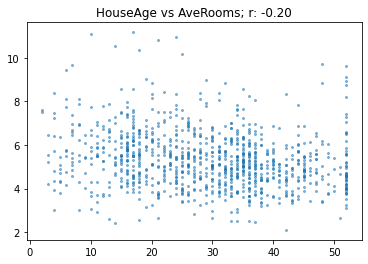

In [34]:
show_corr(subset, 'HouseAge', 'AveRooms')

Transfomers expects metrics to be returned as a `dict`, since that way the trainer knows what label to use. Thus, we create a function to do that.

In [35]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

### Training the Model

In [36]:
from transformers import TrainingArguments, Trainer
batch_size, epochs = 128, 4
learning_rate = 8e-5

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The most important hyperparameter is the learning rate. fastai provides a learning rate finder to help you figure this out, but Transformers doesn't.

In [38]:
args = TrainingArguments('outputs', 
                         learning_rate=learning_rate, 
                         warmup_ratio=0.1,
                         lr_scheduler_type='cosine',
                         fp16=True,
                         evaluation_strategy='epoch',
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=batch_size * 2,
                         num_train_epochs=epochs,
                         weight_decay=0.01,
                         report_to='none')

model = AutoModelForSequenceClassification.from_pretrained(model_nm,
                                                           num_labels=1)

trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr_d)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [39]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, input, target, context, id. If anchor, input, target, context, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27354
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 428
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.027318,0.789600
2,No log,0.022547,0.822281
3,No log,0.023109,0.826441
4,No log,0.023156,0.829245


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, input, target, context, id. If anchor, input, target, context, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 512
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, input, target, context, id. If anchor, input, target, context, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 512
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, input, target, context, id. If anchor, in

TrainOutput(global_step=428, training_loss=0.026866721215649186, metrics={'train_runtime': 178.245, 'train_samples_per_second': 613.852, 'train_steps_per_second': 2.401, 'total_flos': 747252572998440.0, 'train_loss': 0.026866721215649186, 'epoch': 4.0})